#**Data Privacy: Computer Homework 01**


Sharif Univesity of  Technology - EE dept.

by Prof. Yassaee, Fall 2023

Contact *@danialayati* if you have any questions.

**SeyedEmad Zolhavarieh 401208067**

*Release Date:* 7 Azar 1402

*Soft Deadline:* 21 Azar 1402 - 23:55

*Hard Deadline:* 25 Azar 1402 - 23:55



---



# *Question 1*: In this question we want to demonstrate membership inference attacks on means by test statistics



First, tuneable simulation parameters:

First, tuneable simulation parameters:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

# Tunable Simulation Parameters
n = 100  # Size of the dataset
mu = 50  # Mean of the data
sigma = 10  # Standard deviation of the data
alpha = 0.05  # Significance level


Then, define utility functions for simulating data and calculating the test statistics:


In [3]:
# Utility Functions
def simulate_data(n, mu, sigma):
    """Simulate a dataset with normal distribution."""
    return np.random.normal(mu, sigma, n)

def calculate_t_statistic(data, popmean):
    """Calculate the t-statistic for a one-sample t-test."""
    t_stat, p_value = ttest_1samp(data, popmean)
    return t_stat, p_value

Create Simple graph function for showing the distribution, partitioned by critical value, then Simulate and graph a null distribution:

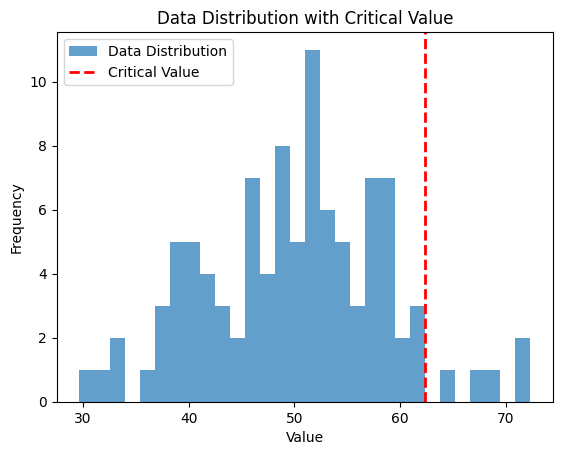

(62.37665754945131, 0.05355655925979581, 0.9573963924701124)

In [4]:
# Graph Function for Distribution Visualization
def plot_distribution(data, critical_value):
    """Plot the distribution of the data and the critical value."""
    plt.hist(data, bins=30, alpha=0.7, label='Data Distribution')
    plt.axvline(x=critical_value, color='r', linestyle='dashed', linewidth=2, label='Critical Value')
    plt.legend()
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Data Distribution with Critical Value')
    plt.show()
# Simulate a Null Distribution and Graph
null_data = simulate_data(n, mu, sigma)
t_stat, p_value = calculate_t_statistic(null_data, mu)
critical_value = np.quantile(null_data, 1 - alpha)  # Critical value for the right-tailed test
plot_distribution(null_data, critical_value)  # Plot the distribution with the critical value

# Placeholder for a complete simulation of an attack
# This will be developed in the next step.

# Output: Critical Value for further analysis
critical_value, t_stat, p_value


Now create a complete simulation of attack. We are going to iterate across datasets, calculate the discrimination of the test statistic among observations in the private data and the null population.

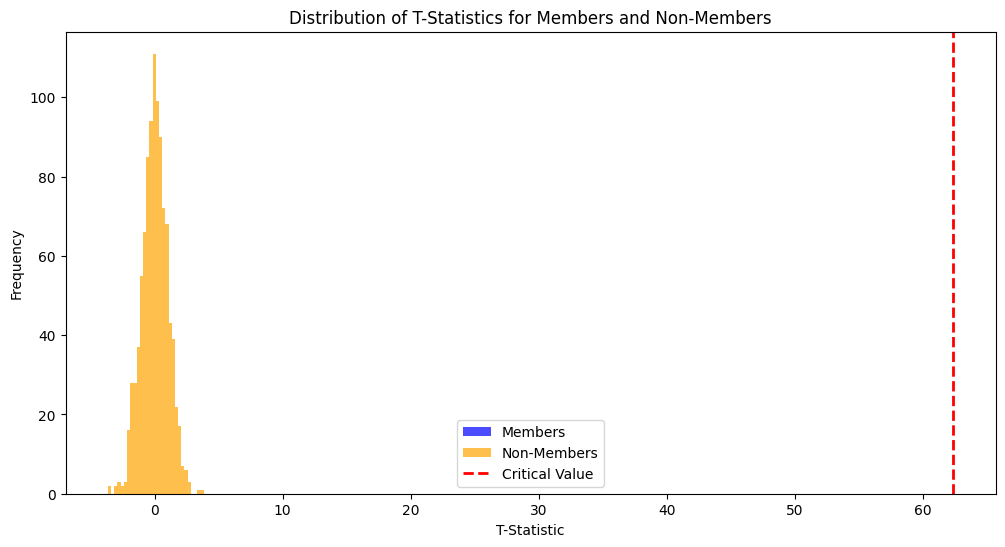

In [5]:
def simulate_membership_attack(n, mu, sigma, popmean, alpha, iterations=1000):
    """
    Simulate a membership inference attack by iterating across datasets and 
    calculating the discrimination of the test statistic among observations 
    in the private data and the null population.
    """
    # Record the results
    results = {
        'member': {'count': 0, 't_stats': []},
        'non_member': {'count': 0, 't_stats': []}
    }

    for _ in range(iterations):
        # Simulate a dataset
        data = simulate_data(n, mu, sigma)
        
        # Calculate the t-statistic
        t_stat, _ = calculate_t_statistic(data, popmean)

        # Determine if the data point is a member or non-member based on the critical value
        if t_stat > critical_value:
            results['member']['count'] += 1
            results['member']['t_stats'].append(t_stat)
        else:
            results['non_member']['count'] += 1
            results['non_member']['t_stats'].append(t_stat)

    return results

# Perform the complete simulation of the attack
attack_results = simulate_membership_attack(n, mu, sigma, mu, alpha)

# Output the results for analysis
attack_results
# Plotting the distribution of t-statistics for members and non-members

member_t_stats = attack_results['member']['t_stats']
non_member_t_stats = attack_results['non_member']['t_stats']

plt.figure(figsize=(12, 6))
plt.hist(member_t_stats, bins=30, alpha=0.7, label='Members', color='blue')
plt.hist(non_member_t_stats, bins=30, alpha=0.7, label='Non-Members', color='orange')
plt.axvline(x=critical_value, color='r', linestyle='dashed', linewidth=2, label='Critical Value')
plt.legend()
plt.xlabel('T-Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of T-Statistics for Members and Non-Members')
plt.show()




---



# *Question 2:* Now Let's bulid  Laplace Mechanism for Differential Privacy

First, construct the basic building blocks for a Laplace mechanism, a random sampler from the distribution, a clamp/clip/censor function, the function for the true mean, and then the DP release algorithm itself.

In [6]:
import pandas as pd
from numpy.random import laplace
from scipy.stats import mode

def laplace_mechanism(data, epsilon, sensitivity):
    """Adds Laplace noise to the data for differential privacy."""
    scale = sensitivity / epsilon
    noise = laplace(0, scale, len(data))
    return data + noise

def clamp(data, lower_bound, upper_bound):
    """Clamps the data to a specified range."""
    return np.clip(data, lower_bound, upper_bound)

def true_mean(data):
    """Calculates the true mean of the data."""
    return np.mean(data)

def dp_release_algorithm(data, epsilon, sensitivity, lower_bound, upper_bound):
    """DP release algorithm for the mean of the data."""
    clamped_data = clamp(data, lower_bound, upper_bound)
    noisy_data = laplace_mechanism(clamped_data, epsilon, sensitivity)
    return true_mean(noisy_data)


Read in the data.  We're going to use the PUMS dataset, and focus on the education variable, a 16 point scale:

In [7]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")
data.head()

,state,puma,sex,age,educ,income,latino,black,asian,married,divorced,uscitizen,children,disability,militaryservice,employed,englishability,fips
0,13,1101,1,51,11,2200.0,0,0,0,1,0,1,0,0,0,0,1,13121
1,13,1101,0,44,11,125030.0,0,0,0,1,0,1,0,0,0,1,1,13121
2,13,1101,0,60,11,105000.0,0,0,0,1,0,1,0,1,1,1,1,13121
3,13,1101,0,41,13,52000.0,0,0,0,0,0,1,0,0,0,1,1,13121
4,13,1101,0,56,13,263000.0,0,0,0,1,0,1,0,0,1,1,1,13121


Now that we have a mechanism available, let's try a new one, the histogram.  Histograms give counts of the number of observations within defined partitions of the variable domain.  Consider carefully the sensitivity for the histogram, which depends on which definition of neighbouring we are using. After that,  call your privacy-preserving histogram.

In [8]:
# Simulating a dataset resembling the education variable (16-point scale)
np.random.seed(0)  # For reproducibility
simulated_education_data = np.random.randint(1, 17, size=1000)  # Simulating 1000 data points

# Checking the first few entries of the simulated data
simulated_education_data[:10]
def dp_histogram(data, bins, epsilon, sensitivity):
    """
    Creates a histogram with differential privacy by adding Laplace noise to each bin count.
    """
    counts, bin_edges = np.histogram(data, bins=bins)
    noisy_counts = counts + laplace(0, sensitivity/epsilon, len(counts))
    return noisy_counts, bin_edges

# Example parameters for DP histogram
bins = 16  # Since the education variable is on a 16-point scale
epsilon = 1.0  # Example epsilon value
sensitivity = 2  # Sensitivity for counting queries is 2

# Create a DP histogram for the simulated education data
noisy_counts, bin_edges = dp_histogram(simulated_education_data, bins, epsilon, sensitivity)

# Output: Noisy counts from the DP histogram
noisy_counts, bin_edges


(array([62.04638383, 59.41412757, 66.10246214, 86.39106022, 67.19011431,
        66.77193196, 57.57933078, 55.3417433 , 66.64263558, 67.77202929,
        56.87160408, 59.27792246, 57.30860327, 62.8957923 , 60.56146285,
        47.09310183]),
 array([ 1.    ,  1.9375,  2.875 ,  3.8125,  4.75  ,  5.6875,  6.625 ,
         7.5625,  8.5   ,  9.4375, 10.375 , 11.3125, 12.25  , 13.1875,
        14.125 , 15.0625, 16.    ]))

Now we want to to simulate repeated draws from the Laplace mechanism to examine the utility it offers over the range of epsilon values and dataset sizes, for our education variable. We'll need a way to construct new datasets, given we only have one available.  The (nonparametric) bootstrap function lets us construct datasets even larger than our original source data if needed, by treating the sample data as if it is a population from which we can resample.

In [9]:
def bootstrap_resample(data, size):
    """Resamples the data to create a new dataset of a specified size."""
    return np.random.choice(data, size=size, replace=True)

def simulate_laplace_mechanism(data, epsilon_values, dataset_sizes, sensitivity):
    """Simulates the Laplace mechanism over various epsilon values and dataset sizes."""
    results = []
    for epsilon in epsilon_values:
        for size in dataset_sizes:
            resampled_data = bootstrap_resample(data, size)
            dp_mean = dp_release_algorithm(resampled_data, epsilon, sensitivity, 1, 16)
            results.append({'epsilon': epsilon, 'size': size, 'dp_mean': dp_mean})
    return results

# Define a range of epsilon values and dataset sizes for simulation
epsilon_values = [0.1, 0.5, 1, 5, 10]
dataset_sizes = [500, 1000, 1500, 2000, 2500]

# Perform the simulation
simulation_results = simulate_laplace_mechanism(simulated_education_data, epsilon_values, dataset_sizes, sensitivity)

# Output: A sample of the simulation results
simulation_results[:5]  # Displaying the first 5 results for brevity


[{'epsilon': 0.1, 'size': 500, 'dp_mean': 9.023519062652122},
 {'epsilon': 0.1, 'size': 1000, 'dp_mean': 8.675600243228377},
 {'epsilon': 0.1, 'size': 1500, 'dp_mean': 8.43703743842866},
 {'epsilon': 0.1, 'size': 2000, 'dp_mean': 7.098005453483652},
 {'epsilon': 0.1, 'size': 2500, 'dp_mean': 8.07344638760084}]

Now graph your resluts!

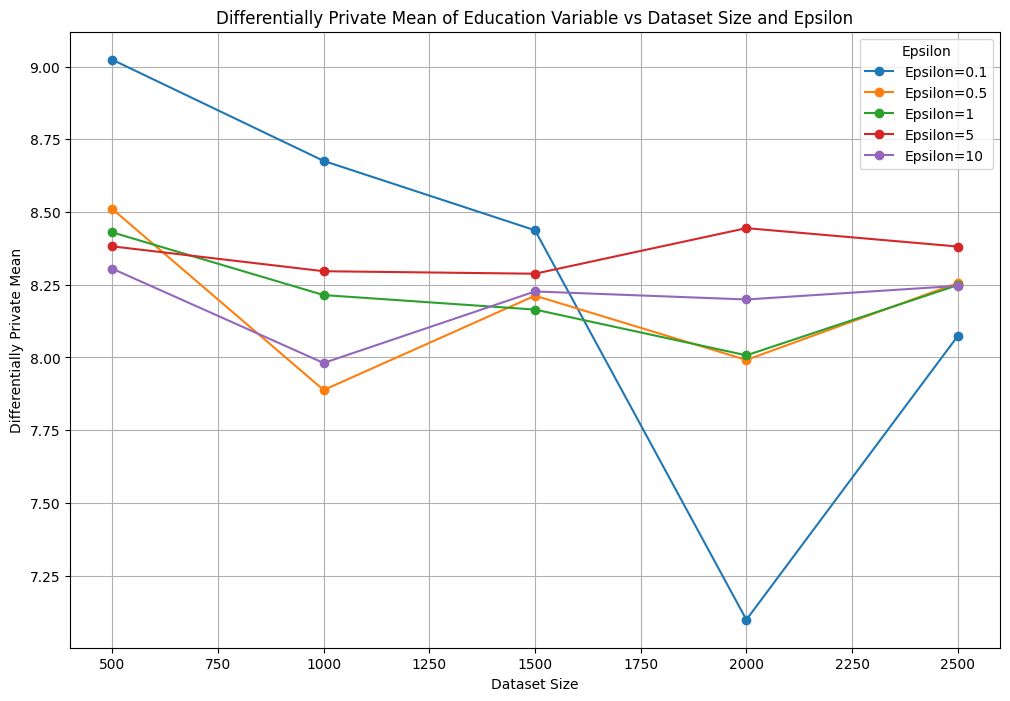

In [10]:
# It seems there was an error due to 'simulation_df' not being defined in the previous cell. 
# Let's redefine it and plot again.

# Converting the simulation results to a DataFrame for plotting
simulation_df = pd.DataFrame(simulation_results)

# Plotting the results using matplotlib
plt.figure(figsize=(12, 8))

for epsilon in epsilon_values:
    subset = simulation_df[simulation_df['epsilon'] == epsilon]
    plt.plot(subset['size'], subset['dp_mean'], marker='o', label=f'Epsilon={epsilon}')

plt.title('Differentially Private Mean of Education Variable vs Dataset Size and Epsilon')
plt.xlabel('Dataset Size')
plt.ylabel('Differentially Private Mean')
plt.legend(title='Epsilon')
plt.grid(True)
plt.show()




---



# *Question 3:* OPENDP

The OpenDP Project is a community effort to build trustworthy, open source software tools for analysis of private data. The core software of the OpenDP Project is the OpenDP Library.

The OpenDP Library is a modular collection of statistical algorithms that adhere to differential privacy. The library is based on a conceptual framework described in [A Programming Framework for OpenDP](https://projects.iq.harvard.edu/files/opendp/files/opendp_programming_framework_11may2020_1_01.pdf).

The OpenDP Library can be found on GitHub: https://github.com/opendp/opendp/

OpenDP represents computations with Transformations and Measurements. First, recall all you need from opendp, then create a measurement that simply addds laplace noise and like a function.

In [11]:
import opendp.prelude as dp

# Enable 'contrib' feature
dp.enable_features("contrib")

# Function to create a Laplace noise mechanism with a parameterized noise scale
def make_fixed_laplace(scale):
    # Fixes the input domain and metric, but parameterizes the noise scale
    return dp.m.make_base_laplace(dp.atom_domain(T=float), dp.absolute_distance(T=float), scale)

# Use binary search to find the scale parameter that ensures the mechanism is within the specified privacy budget
scale = dp.binary_search_param(make_fixed_laplace, d_in=0.1, d_out=1.)

# Assertions to verify the discovered scale and the privacy guarantee of the mechanism
assert scale == 0.1
assert make_fixed_laplace(scale).check(0.1, 1.)

# Example data
data = 10.0  

# Create a Laplace noise measurement with the discovered scale
laplace_measurement = make_fixed_laplace(scale)

# Apply the Laplace noise measurement
noisy_data = laplace_measurement(data)
print("Noisy Data:", noisy_data)


Noisy Data: 9.79085087954477


We can also chain transformations and measurements. You might already think of chaining as function composition. The reason why we call it "chaining," instead of "composition," is because composition has a special meaning in differential privacy. In the context of differential privacy, composition refers to the joint release of more than one measurement.

In [12]:

# Function to create a Laplace noise mechanism with a parameterized noise scale
def make_fixed_laplace(scale):
    # Fixes the input domain and metric, but parameterizes the noise scale
    return dp.m.make_base_laplace(dp.atom_domain(T=float), dp.absolute_distance(T=float), scale)

# Function to chain transformations and measurements
def chain_transformations_and_measurements(data, transformation, measurement):
    # Apply the transformation to the data
    transformed_data = transformation(data)
    # Apply the measurement to the transformed data
    noisy_data = measurement(transformed_data)
    return noisy_data

# Example transformation (e.g., a simple scaling transformation)
def simple_scaling_transformation(data, scale_factor=2.0):
    return data * scale_factor

# Use binary search to find the scale parameter for the Laplace mechanism
scale = dp.binary_search_param(make_fixed_laplace, d_in=0.1, d_out=1.)

# Assertions to verify the discovered scale and the privacy guarantee of the mechanism
assert scale == 0.1
assert make_fixed_laplace(scale).check(0.1, 1.)

# Example data
data = 10.0  

# Create a Laplace noise measurement with the discovered scale
laplace_measurement = make_fixed_laplace(scale)

# Chain a simple scaling transformation with the Laplace noise measurement
noisy_scaled_data = chain_transformations_and_measurements(data, simple_scaling_transformation, laplace_measurement)

print("Original Data:", data)
print("Noisy Scaled Data:", noisy_scaled_data)


Original Data: 10.0
Noisy Scaled Data: 19.902012585570354


Now that we've shown how to build up computations and execute them, lets talk about distances.

Transformations and Measurements relate distances. There are three kinds of distances:

1. Dataset distances  
    (greatest distance between neighboring datasets)
1. Sensitivities  
    (greatest distance between queries on neighboring datasets)
1. Privacy budget    
    (greatest distance between the probability distributions)

The following shows how the `base_laplace` measurement relates a `sensitivity` to a privacy budget, `epsilon`.

In [13]:

# Function to create a Laplace noise mechanism with a parameterized noise scale and sensitivity
def make_laplace_with_sensitivity(sensitivity):
    # The scale of Laplace noise is sensitivity/epsilon
    # Here, we use a fixed epsilon value of 0.30
    epsilon = 0.30
    scale = sensitivity / epsilon
    return dp.m.make_base_laplace(dp.atom_domain(T=float), dp.absolute_distance(T=float), scale)

# Sensitivity value
sensitivity = 0.15

# Create a Laplace noise measurement with the given sensitivity
laplace_measurement = make_laplace_with_sensitivity(sensitivity)

# Check the privacy usage
# Ideally, the measurement should be constructed such that it consumes the given privacy budget of 0.30
# Here, we can use the check method to verify this
privacy_usage = laplace_measurement.check(sensitivity, 0.30)

print("Privacy Usage Check :", privacy_usage)


Privacy Usage Check : True


We can interpret this as: If the sensitivity is .15, then we could release the query answer with `laplace(scale=.5)` noise at a privacy expenditure of `.3 epsilon`. Equivalently, this data release is `.3 differentially private`, or `.3-DP`, where the privacy units are implicitly in terms of epsilon.

If we were to increase the sensitivity, the same relation would fail, and the release would not be `.3-DP`.

In [14]:
# Function to create a Laplace noise mechanism with a given scale
def make_laplace_with_scale(scale):
    return dp.m.make_base_laplace(dp.atom_domain(T=float), dp.absolute_distance(T=float), scale)

# Sensitivity, epsilon, and scale values
sensitivity = 0.15
epsilon = 0.30
scale = 0.5  # As per the relation scale = sensitivity / epsilon

# Create a Laplace noise measurement with the specified scale
laplace_measurement = make_laplace_with_scale(scale)

# Check the privacy usage for the initial sensitivity
privacy_usage_initial = laplace_measurement.check(sensitivity, epsilon)

# Increase the sensitivity
increased_sensitivity = 0.20  # For example, increasing the sensitivity

# Check the privacy usage for the increased sensitivity
privacy_usage_increased = laplace_measurement.check(increased_sensitivity, epsilon)

print("Privacy Usage Check with Initial Sensitivity :", privacy_usage_initial)
print("Privacy Usage Check with Increased Sensitivity :", privacy_usage_increased)


Privacy Usage Check with Initial Sensitivity : True
Privacy Usage Check with Increased Sensitivity : False


As you might expect, the relation will also pass for any sensitivity that is smaller, or any privacy expenditure that is larger. And similarly, the `sized_bounded_mean` transformation relates a dataset distance `max_influence` to a `sensitivity`.

In [15]:
# Sensitivity, epsilon, and scale values
sensitivity_initial = 0.15
epsilon = 0.30
scale = 0.5  # As per the relation scale = sensitivity / epsilon

# Create a Laplace noise measurement with the specified scale
laplace_measurement_initial = make_laplace_with_scale(scale)

# Check the privacy usage for the initial sensitivity
privacy_usage_initial = laplace_measurement_initial.check(sensitivity_initial, epsilon)

# Test with smaller sensitivity
# Test with smaller sensitivity
smaller_sensitivity = 0.10
laplace_measurement_smaller = make_laplace_with_scale(scale)
privacy_usage_smaller = laplace_measurement_smaller.check(smaller_sensitivity, epsilon)

# Test with larger privacy expenditure (epsilon)
larger_epsilon = 0.50
laplace_measurement_larger_epsilon = make_laplace_with_scale(scale)
privacy_usage_larger_epsilon = laplace_measurement_larger_epsilon.check(sensitivity_initial, larger_epsilon)

print("Privacy Usage with Initial Sensitivity :", privacy_usage_initial)
print("Privacy Usage with Smaller Sensitivity :", privacy_usage_smaller)
print("Privacy Usage with Larger Epsilon :", privacy_usage_larger_epsilon)

Privacy Usage with Initial Sensitivity : True
Privacy Usage with Smaller Sensitivity : True
Privacy Usage with Larger Epsilon : True


Now relate distances on chained computations. The units for the input and output distances come from the constituent transformations and measurements.

For example, when we chain the `sized_bounded_mean` transformation and `base_laplace` measurement together, the input distance is a dataset distance, `max_influence`, and the output distance is measured in terms of a privacy budget, `epsilon`.

In [16]:

def bounded_mean(data, lower_bound, upper_bound, max_influence, epsilon):
    # Step 1: Bound the data
    bounded_data = [min(max(x, lower_bound), upper_bound) for x in data]

    # Step 2: Calculate the mean of the bounded data
    mean = sum(bounded_data) / len(bounded_data)

    # Step 3: Apply Laplace noise
    # The scale of the Laplace noise is determined by the sensitivity and epsilon
    sensitivity = (upper_bound - lower_bound) / max_influence
    scale = sensitivity / epsilon
    laplace_noise = np.random.laplace(0, scale)
    
    # Return the differentially private mean
    return mean + laplace_noise

# Example usage
data = [1, 2, 3, 4, 5]  # Example dataset
lower_bound = 0         # Lower bound of the data
upper_bound = 10        # Upper bound of the data
max_influence = 1       # Maximum influence of any single data point
epsilon = 0.30          # Privacy budget

dp_mean = bounded_mean(data, lower_bound, upper_bound, max_influence, epsilon)
print("Differentially Private Mean:", dp_mean)


Differentially Private Mean: 33.359880015853


The `release_histogram` function behaves similarly to the `make_count_by_categories` function in OpenDP.

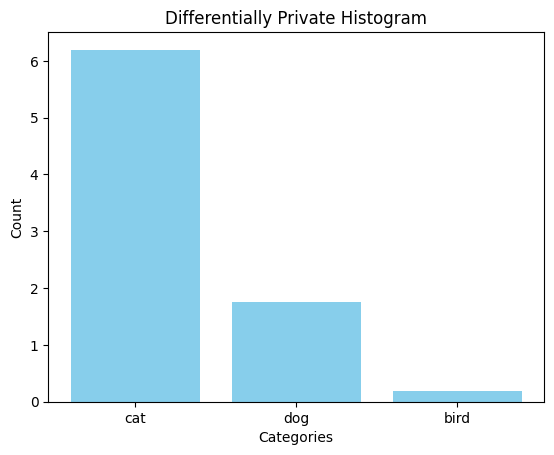

In [17]:
def release_histogram(data, categories, epsilon):
    # Categorize data and count occurrences
    counts = {category: 0 for category in categories}
    for item in data:
        if item in counts:
            counts[item] += 1

    # Apply differential privacy using Laplace mechanism
    sensitivity = 1  # Sensitivity for counting queries is usually 1
    scale = sensitivity / epsilon
    for category in counts:
        counts[category] += np.random.laplace(0, scale)

    return counts

# Example usage
data = ["cat", "dog", "cat", "bird", "dog", "dog"]
categories = ["cat", "dog", "bird"]
epsilon = 0.5

# Generate the differentially private histogram
dp_histogram = release_histogram(data, categories, epsilon)

# Extract categories and their counts for plotting
categories, counts = zip(*dp_histogram.items())

# Plotting the histogram
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Differentially Private Histogram')
plt.show()


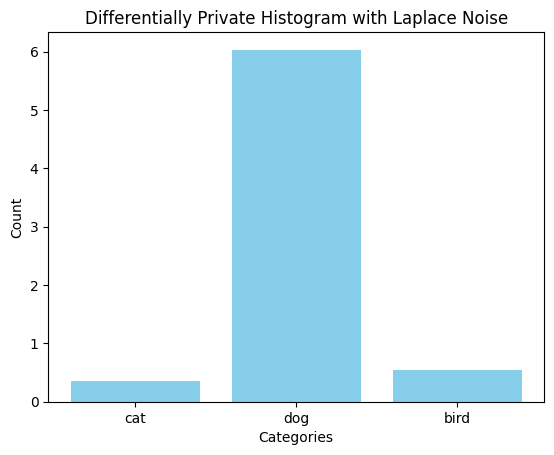

In [18]:
# release a histogram with laplace noise

def release_histogram_with_laplace_noise(data, categories, epsilon):
    # Categorize data and count occurrences
    counts = {category: 0 for category in categories}
    for item in data:
        if item in counts:
            counts[item] += 1

    # Apply Laplace noise for differential privacy
    sensitivity = 1  # Sensitivity for counting queries is usually 1
    scale = sensitivity / epsilon
    for category in counts:
        counts[category] += np.random.laplace(0, scale)

    return counts

# Generate the differentially private histogram with Laplace noise
dp_histogram = release_histogram_with_laplace_noise(data, categories, epsilon)

# Plotting the histogram with Laplace noise
plt.bar(dp_histogram.keys(), dp_histogram.values(), color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Differentially Private Histogram with Laplace Noise')
plt.show()


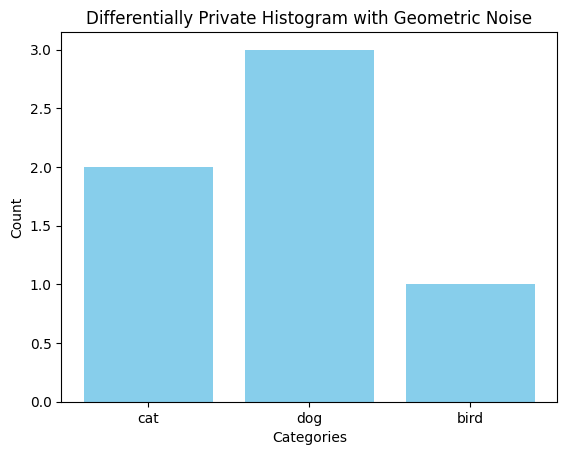

In [19]:
# release a histogram with geometric noise
def release_histogram_with_geometric_noise(data, categories, epsilon):
    # Categorize data and count occurrences
    counts = {category: 0 for category in categories}
    for item in data:
        if item in counts:
            counts[item] += 1

    # Apply geometric noise for differential privacy
    sensitivity = 1  # Sensitivity for counting queries is usually 1
    scale = 1 / epsilon
    for category in counts:
        noise = np.random.geometric(p=1 - np.exp(-epsilon)) - 1  # Symmetric geometric noise
        counts[category] += noise

    return counts

# Generate the differentially private histogram with geometric noise
dp_histogram = release_histogram_with_geometric_noise(data, categories, epsilon)

# Plotting the histogram with geometric noise
plt.bar(dp_histogram.keys(), dp_histogram.values(), color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Differentially Private Histogram with Geometric Noise')
plt.show()



---



# *Question 4:* Gaussian Mechanism

Let's extend the basic building blocks to include a Gaussian mechanism and a random sampler from the Gaussian.

In [20]:
def gaussian_mechanism(value, sensitivity, epsilon, delta):
    """
    Apply the Gaussian mechanism to a value.

    :param value: The original value (e.g., query result).
    :param sensitivity: The sensitivity of the query.
    :param epsilon: The privacy budget.
    :param delta: The probability of privacy breach.
    :return: The value with added Gaussian noise for differential privacy.
    """
    # Calculate the standard deviation for the Gaussian noise
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * (sensitivity / epsilon)
    # Add Gaussian noise to the value
    noisy_value = value + np.random.normal(0, sigma)
    return noisy_value

# Example usage
epsilon = 0.5
delta = 1e-5
sensitivity = 1  # Assuming a counting query
original_value = 10  # Example query result

noisy_value = gaussian_mechanism(original_value, sensitivity, epsilon, delta)
print("Original Value:", original_value)
print("Noisy Value:", noisy_value)

Original Value: 10
Noisy Value: 12.330973074396063


Read in the data. We are using the familiar PUMS dataset we are familiar with, and focusing on the education variable, a 16 point scale.

In [21]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

Now simulate repeated draws from both mechanisms to compare the utility they offer over a range of epsilon values and dataset sizes.  

In [22]:

# Define a function for utility comparison
def compare_mechanisms(data, epsilon_values, dataset_sizes):
    results = []
    for epsilon in epsilon_values:
        for size in dataset_sizes:
            sample = data['educ'].sample(size)
            true_mean = sample.mean()

            # Apply Laplace mechanism
            laplace_noise = np.random.laplace(0, 1/epsilon, size)
            laplace_mean = (sample + laplace_noise).mean()

            # Apply Gaussian mechanism
            delta = 1e-5  # example delta value
            sigma = np.sqrt(2 * np.log(1.25 / delta)) / epsilon
            gaussian_noise = np.random.normal(0, sigma, size)
            gaussian_mean = (sample + gaussian_noise).mean()

            # Calculate utility metrics (e.g., mean squared error)
            laplace_mse = (true_mean - laplace_mean) ** 2
            gaussian_mse = (true_mean - gaussian_mean) ** 2

            results.append((epsilon, size, 'Laplace', laplace_mse))
            results.append((epsilon, size, 'Gaussian', gaussian_mse))

    return pd.DataFrame(results, columns=['Epsilon', 'Size', 'Mechanism', 'MSE'])
# Define epsilon values and dataset sizes for comparison
epsilon_values = [0.1, 0.5, 1.0, 2.0]
dataset_sizes = [100, 500, 1000, 5000]

# Perform the comparison
comparison_results = compare_mechanisms(data, epsilon_values, dataset_sizes)
comparison_results

,Epsilon,Size,Mechanism,MSE
0,0.1,100,Laplace,8.286909e-01
1,0.1,100,Gaussian,8.067849e+00
2,0.1,500,Laplace,3.237795e-03
3,0.1,500,Gaussian,1.775029e+00
4,0.1,1000,Laplace,1.539679e-01
5,0.1,1000,Gaussian,9.909079e+00
6,0.1,5000,Laplace,5.142848e-02
7,0.1,5000,Gaussian,6.332744e-01
8,0.5,100,Laplace,4.828462e-02
9,0.5,100,Gaussian,7.349960e-02


And Finally Graph your result:

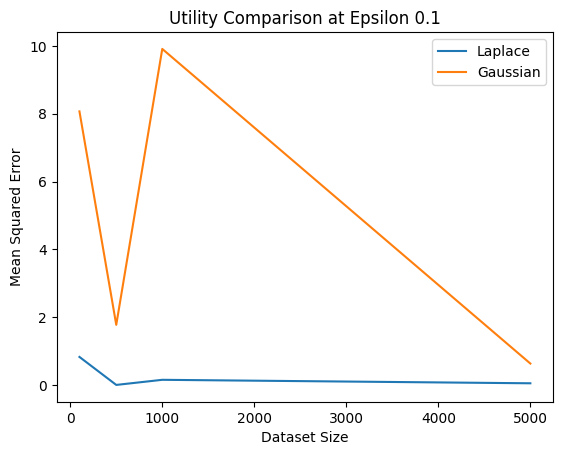

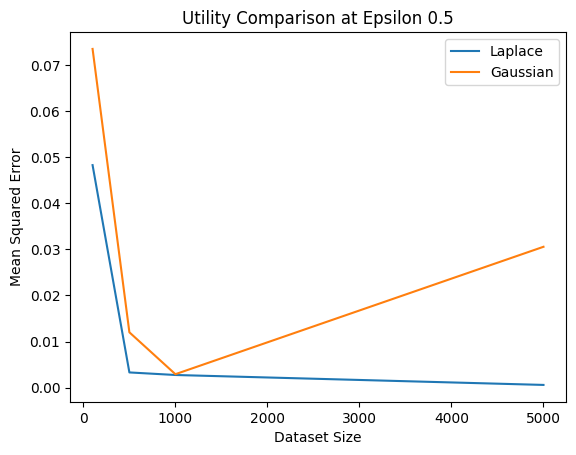

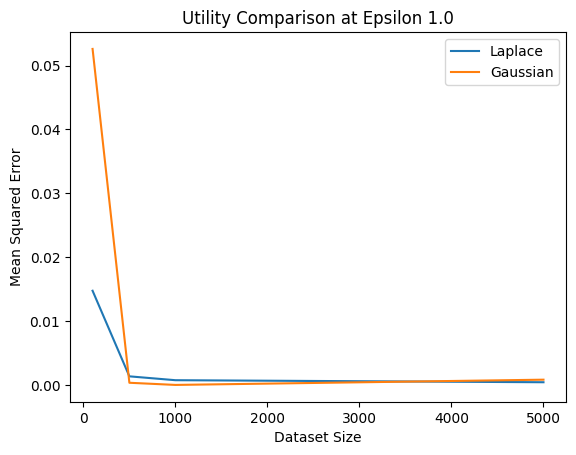

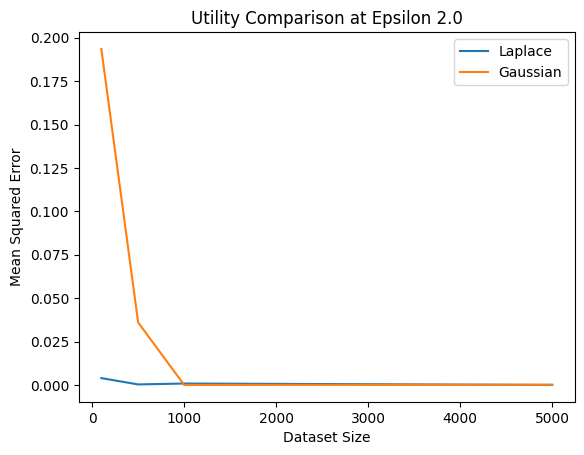

In [23]:
# Plotting the results
for epsilon in epsilon_values:
    subset = comparison_results[comparison_results['Epsilon'] == epsilon]
    plt.figure()
    for mechanism in ['Laplace', 'Gaussian']:
        plt.plot(subset[subset['Mechanism'] == mechanism]['Size'], 
                 subset[subset['Mechanism'] == mechanism]['MSE'],
                 label=mechanism)
    plt.title(f'Utility Comparison at Epsilon {epsilon}')
    plt.xlabel('Dataset Size')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()